In [2]:
# import necessary functions
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib widget

In [4]:
from statesim.model.statespace import Linear, Nonlinear
from statesim.simulator import ContinuousSimulator, DiscreteSimulator
from statesim.system.cartpole import CartPole
from statesim.system.coupled_msd import CoupledMsd
from statesim.system.inverted_pendulum import InvertedPendulum
from statesim.analysis.plot_simulation_results import (
    plot_states,
    plot_outputs,
    plot_inputs,
    plot_comparison,
)
from statesim.generate.input import random_static_input
from statesim.noise import NoiseGeneration
from statesim.configuration import InputGeneratorConfig
import numpy as np
import time

step_size = 0.2

# Cartpole

In [59]:
system = CartPole(mu_c=0, mu_p=0.01)
x_bar = np.array([[0], [0], [np.pi], [0]])
A_sym, B_sym = system.get_linearization()
A, B = system.evaluate_linearization(
    A_sym=A_sym, B_sym=B_sym, x_bar=x_bar, u_bar=np.array([[0]])
)
print(f'A_lin: \n{A} \n B_lin: \n{B}')
x0 = np.array([[0.0], [0.0], [np.pi], [0.0]])

lin_model = Linear(
    A=A,
    B=B,
    C=np.array([[0, 0, 1, 0]]),
    D=np.array([[0]]),
)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=4, nu=1, ny=1
)

nx = A.shape[0]
A_d = A * step_size + np.eye(nx)
B_d = B * step_size
C_d = np.array([[0, 0, 1, 0]])
D_d = np.array([[0]])

A_lin: 
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -7.17804878e-01 -1.46341463e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.57917073e+01 -3.21951220e-01]] 
 B_lin: 
[[0.        ]
 [0.97560976]
 [0.        ]
 [1.46341463]]


# Inverted Pendulum

In [22]:
system = InvertedPendulum(mu_p=0.01)
x_bar = np.array([[np.pi], [0]])
A_sym, B_sym = system.get_linearization()
A, B = system.evaluate_linearization(
    A_sym=A_sym, B_sym=B_sym, x_bar=x_bar, u_bar=np.array([[0]])
)
print(f'A_lin: \n{A} \n B_lin: \n{B}')
x0 = np.array([[np.pi], [0]])

lin_model = Linear(
    A=A,
    B=B,
    C=np.array([[1, 0]]),
    D=np.array([[0]]),
)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=2, nu=1, ny=1
)

nx = A.shape[0]
A_d = A * step_size + np.eye(nx)
B_d = B * step_size
C_d = np.array([[1, 0]])
D_d = np.array([[0]])

A_lin: 
[[  0.     1.  ]
 [-19.62  -0.4 ]] 
 B_lin: 
[[ 0.]
 [40.]]


# MSD

In [14]:
x_bar = np.zeros(shape=(8, 1))
system = CoupledMsd()
A_sym, B_sym = system.get_linearization()
A_c, B_c = system.evaluate_linearization(
    A_sym=A_sym,
    B_sym=B_sym,
    x_bar=x_bar,
    u_bar=np.array([[0]]),
)
C_c = np.zeros(shape=(1, 8))
C_c[0, -2] = 1
D_c = np.array([[0]])

x0 = np.zeros(shape=(8, 1))

lin_model = Linear(
    A=A_c,
    B=B_c,
    C=C_c,
    D=D_c,
)
print(type(system.state_dynamics))
print(system._f)

nl_model = Nonlinear(
    f=system.state_dynamics, g=system.output_function, nx=8, nu=1, ny=1
)


A_d = A_c * step_size + np.eye(system.nx)
B_d = B_c * step_size
C_d = C_c
D_d = D_c

<class 'method'>
<function _lambdifygenerated at 0x12ab6ab00>


# Simulation

In [19]:
T_end = 40
N = int(T_end / step_size)
print(N)
us = [np.array([[u]]) for u in np.zeros(N)]
us = random_static_input(
    N=N,
    nu=1,
    config=InputGeneratorConfig(
        type='random_static_input',
        u_min=-1.5,
        u_max=1.5,
        interval_min=10,
        interval_max=20,
    ),
)

noise_config = NoiseGeneration('gaussian', 0.0, 0.03)
sim = ContinuousSimulator(T=T_end, step_size=step_size)

start_time = time.time()
lin_res = sim.simulate(
    model=lin_model, initial_state=x0, input=us, name='lin', x_bar=x_bar
)
print(
    f'simulation time linear continuous: {time.strftime("%H:%M:%S", time.gmtime(float(time.time() - start_time)))}'
)


start_time = time.time()
# %prun nl_res = sim.simulate(model=nl_model,initial_state=x0,input=us,name='non lin',noise_config=noise_config)
nl_res = sim.simulate(
    model=nl_model,
    initial_state=x0,
    input=us,
    name='non lin',
    noise_config=noise_config,
)
print(
    f'simulation time nonlinear continuous: {time.strftime("%H:%M:%S", time.gmtime(float(time.time() - start_time)))}'
)

lin_model_d = Linear(
    A=A_d,
    B=B_d,
    C=C_d,
    D=D_d,
)

sim_d = DiscreteSimulator(T=T_end, step_size=step_size)

start_time = time.time()
lin_res_d = sim_d.simulate(
    model=lin_model_d, initial_state=x0, input=us, name='lin disc', x_bar=x_bar
)
print(
    f'simulation time linear discrete: {time.strftime("%H:%M:%S", time.gmtime(float(time.time() - start_time)))}'
)

200
simulation time linear continuous: 00:00:00
simulation time nonlinear continuous: 00:06:06
simulation time linear discrete: 00:00:00


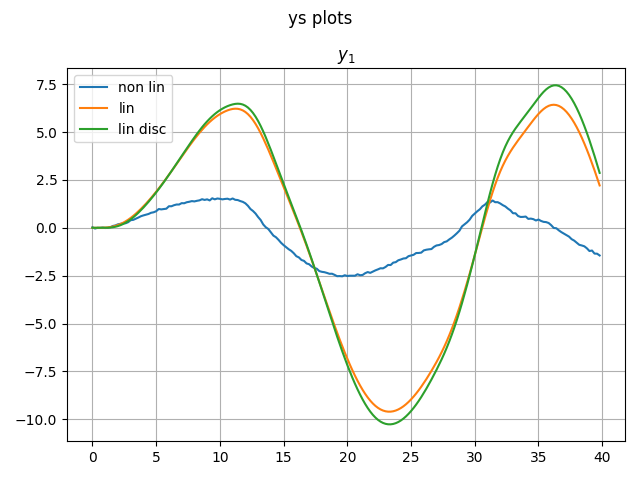

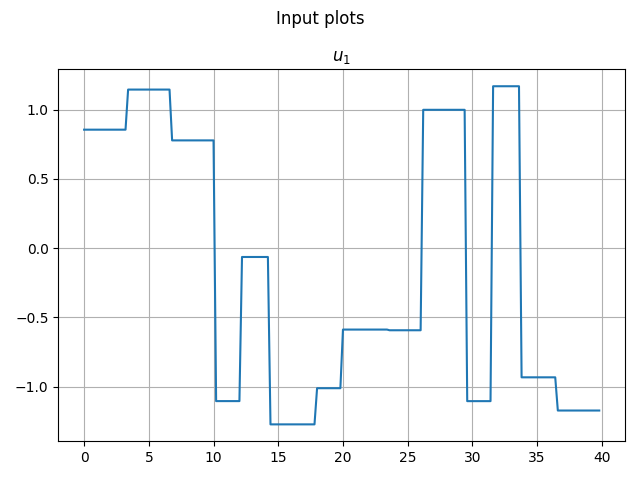

In [20]:
plot_comparison(results=[nl_res, lin_res, lin_res_d], type='ys')
# plot_outputs(result=nl_res)
plot_inputs(result=lin_res)